In [142]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

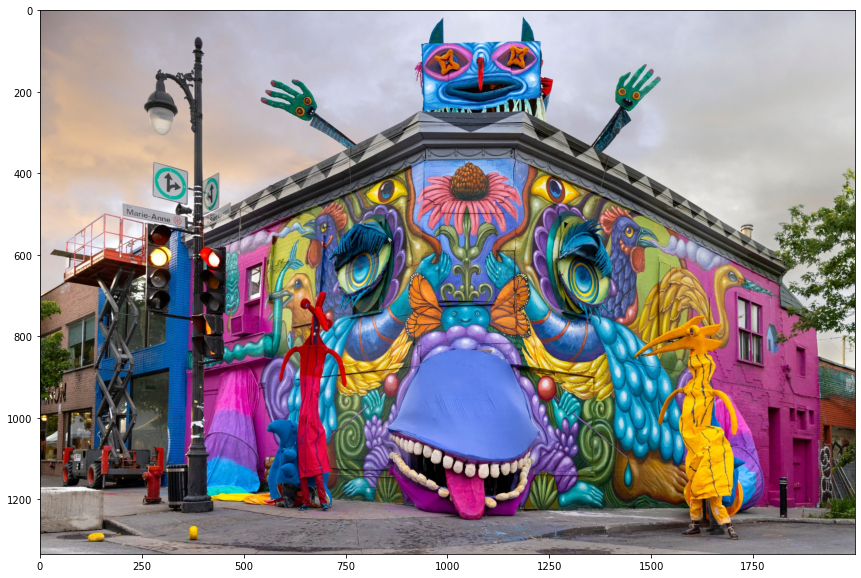

In [143]:
# Load image
img = cv2.imread('../Data/brissonnet.jpg')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

In [144]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

In [145]:
# Cast the image to float
img = np.float32(img)

# Prepare for quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)

from scipy.spatial import distance

# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img[r, c, :]
        
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        dist = 255**2
        for color in colors:
            d = distance.euclidean(pixel, color)
            if d < dist:
                dist = d
                new_pixel = color
        # Apply quantization
        quantized[r, c, :] = new_pixel

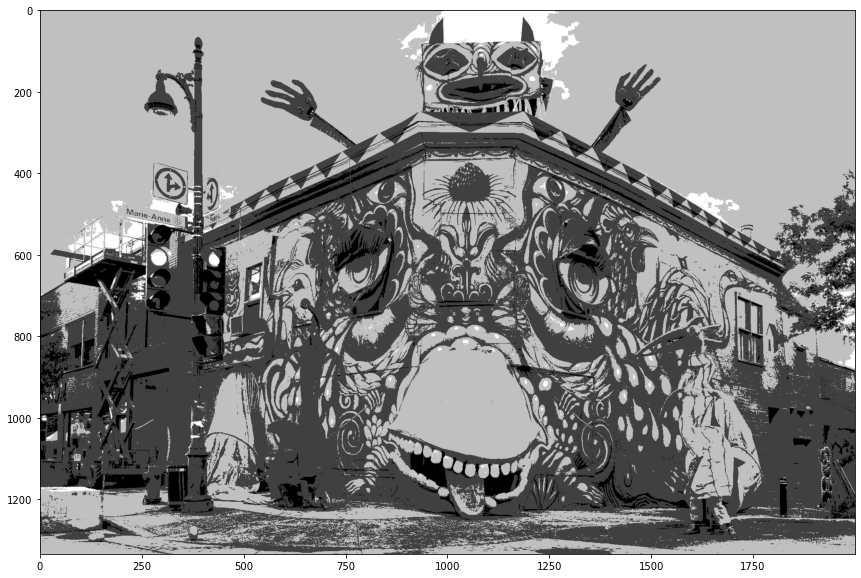

In [146]:
# Show quantized image (don't forget to cast back to uint8)
plt.imshow(np.uint8(quantized))

In [147]:
# Compute average quantization error
def psnr(ref, target):
    error = ref.astype(np.float32) - target.astype(np.float32)
    mse = np.mean(error**2)
    return 10 * np.log10((255**2)/mse)
avg_quant_error = psnr(img, quantized)
print('Average quantization error as PSNR:', avg_quant_error, 'dB')

Average quantization error as PSNR: 14.783478823727519 dB


In [148]:
# Make a temporal copy of the original image, we will need it for error diffusion
img_tmp = np.copy(img)
dithering = np.zeros_like(img)

for r in range(1, rows-1):
    for c in range(1, cols-1):
        # Extract the original pixel value
        pixel = img_tmp[r, c, :]
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        dist = 255**2
        for color in colors:
            d = distance.euclidean(pixel, color)
            if d < dist:
                dist = d
                new_pixel = color        
        
        # Compute quantization error
        quant_error = pixel - new_pixel
        
        # Diffuse the quantization error accroding to the FS diffusion matrix
        # Note: You may need more than one line of code here
        for ch in range(0,3):
            img_tmp[r    , c + 1, ch] = img_tmp[r    , c + 1, ch] + quant_error[ch] * 7 / 16
            img_tmp[r + 1, c - 1, ch] = img_tmp[r + 1, c - 1, ch] + quant_error[ch] * 3 / 16
            img_tmp[r + 1, c    , ch] = img_tmp[r + 1, c    , ch] + quant_error[ch] * 5 / 16
            img_tmp[r + 1, c + 1, ch] = img_tmp[r + 1, c + 1, ch] + quant_error[ch] * 1 / 16
        
        # Apply dithering
        dithering[r, c, :] = new_pixel

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7f59a3400820>)

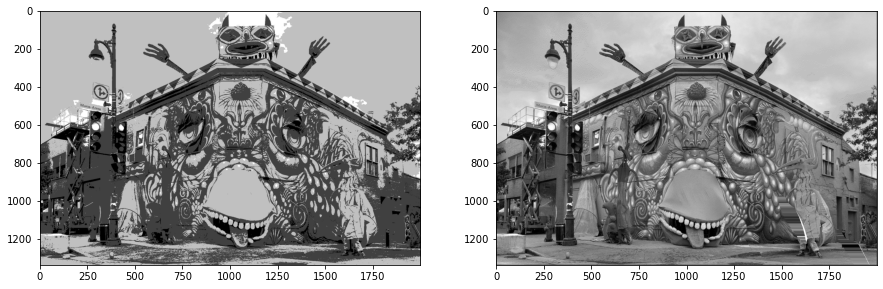

In [149]:
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(np.uint8(quantized))   # optimally quantized
plt.subplot(122), plt.imshow(np.uint8(dithering))   # dithering

In [150]:
# Compute average quantization error for dithered image
avg_dith_error = psnr(img, dithering)
print('Average quantization error as PSNR:', avg_dith_error, 'dB')

Average quantization error as PSNR: 13.240761944156194 dB


*Answers*
1. Dithered image has a large quantization error.
2. Dithered image looks better to me.
3. See below

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7f59a34777f0>)

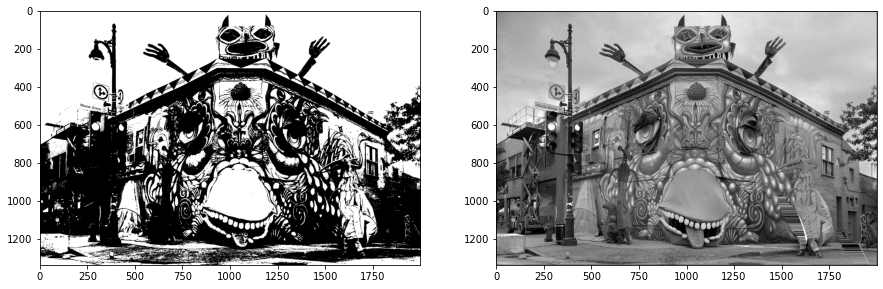

In [154]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [255, 255, 255]])

# Quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)

from scipy.spatial import distance

# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img[r, c, :]
        
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        dist = 255**2
        for color in colors:
            d = distance.euclidean(pixel, color)
            if d < dist:
                dist = d
                new_pixel = color
        # Apply quantization
        quantized[r, c, :] = new_pixel

# Dithering
img_tmp = np.copy(img)
dithering = np.zeros_like(img)

for r in range(1, rows-1):
    for c in range(1, cols-1):
        # Extract the original pixel value
        pixel = img_tmp[r, c, :]
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        dist = 255**2
        for color in colors:
            d = distance.euclidean(pixel, color)
            if d < dist:
                dist = d
                new_pixel = color        
        
        # Compute quantization error
        quant_error = pixel - new_pixel
        
        # Diffuse the quantization error accroding to the FS diffusion matrix
        # Note: You may need more than one line of code here
        for ch in range(0,3):
            img_tmp[r    , c + 1, ch] = img_tmp[r    , c + 1, ch] + quant_error[ch] * 7 / 16
            img_tmp[r + 1, c - 1, ch] = img_tmp[r + 1, c - 1, ch] + quant_error[ch] * 3 / 16
            img_tmp[r + 1, c    , ch] = img_tmp[r + 1, c    , ch] + quant_error[ch] * 5 / 16
            img_tmp[r + 1, c + 1, ch] = img_tmp[r + 1, c + 1, ch] + quant_error[ch] * 1 / 16
        
        # Apply dithering
        dithering[r, c, :] = new_pixel

# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(np.uint8(quantized))   # optimally quantized
plt.subplot(122), plt.imshow(np.uint8(dithering))   # dithering

In [151]:
# Bonus Points
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=16).fit(np.reshape(img, (-1, 1)))
colors = kmeans.cluster_centers_
print(colors)

[[197.14267 ]
 [ 43.886955]
 [123.71285 ]
 [  5.8582  ]
 [ 92.06643 ]
 [152.84685 ]
 [223.37228 ]
 [168.45853 ]
 [ 75.544106]
 [184.12628 ]
 [137.68454 ]
 [241.86998 ]
 [ 26.361153]
 [108.51656 ]
 [ 59.60408 ]
 [209.26013 ]]


Average quantization error as PSNR: 35.044828063906984 dB


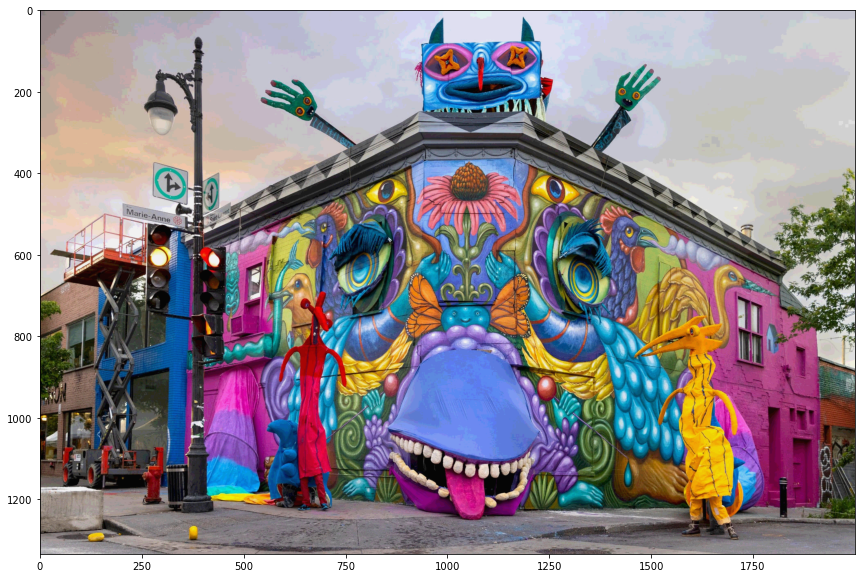

In [152]:
img = np.float32(img)
quantized2 = np.zeros_like(img)

# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img[r, c, :]
        
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        new_pixel = np.zeros_like(pixel)
        #print(pixel, new_pixel)
        for ch in range(0, 3):
            dist = 255**2
            for color in colors:
                d = distance.euclidean(pixel[ch], color[0])
                if d < dist:
                    dist = d
                    new_pixel[ch] = color[0]
                #print(d, color[0])
                    
        # Apply quantization
        quantized2[r, c, :] = new_pixel
        #print(pixel, new_pixel)

        #break
    #break

# Show quantized image (don't forget to cast back to uint8)
plt.imshow(np.uint8(quantized2))
avg_quant_error2 = psnr(img, quantized2)
print('Average quantization error as PSNR:', avg_quant_error2, 'dB')

Average quantization error as PSNR: 13.240761944156194 dB


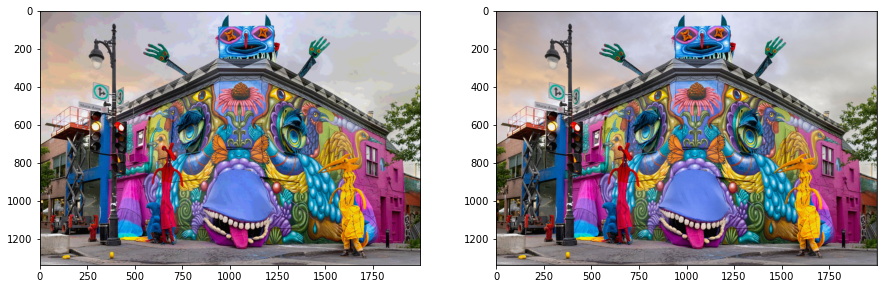

In [153]:
# Make a temporal copy of the original image, we will need it for error diffusion
img_tmp = np.copy(img)
dithering2 = np.zeros_like(img)

for r in range(1, rows-1):
    for c in range(1, cols-1):
        # Extract the original pixel value
        pixel = img_tmp[r, c, :]
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        new_pixel = np.zeros_like(pixel)
        #print(pixel, new_pixel)
        for ch in range(0, 3):
            dist = 255**2
            for color in colors:
                d = distance.euclidean(pixel[ch], color[0])
                if d < dist:
                    dist = d
                    new_pixel[ch] = color[0]        
        
        # Compute quantization error
        quant_error = pixel - new_pixel
        
        # Diffuse the quantization error accroding to the FS diffusion matrix
        # Note: You may need more than one line of code here
        for ch in range(0,3):
            img_tmp[r    , c + 1, ch] = img_tmp[r    , c + 1, ch] + quant_error[ch] * 7 / 16
            img_tmp[r + 1, c - 1, ch] = img_tmp[r + 1, c - 1, ch] + quant_error[ch] * 3 / 16
            img_tmp[r + 1, c    , ch] = img_tmp[r + 1, c    , ch] + quant_error[ch] * 5 / 16
            img_tmp[r + 1, c + 1, ch] = img_tmp[r + 1, c + 1, ch] + quant_error[ch] * 1 / 16
        
        # Apply dithering
        dithering2[r, c, :] = new_pixel

# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(np.uint8(quantized2))   # optimally quantized
plt.subplot(122), plt.imshow(np.uint8(dithering2))   # dithering

# Compute average quantization error for dithered image
avg_dith_error2 = psnr(img, dithering)
print('Average quantization error as PSNR:', avg_dith_error2, 'dB')

*Answers*
1. The result looks not bad. Although with optimal quantization, artifacts are clearly visible.
2. At 32 colors, it is difficult to distinguish the original image from the processed one.
3. At 256 colors, the pictures will be identical because we will use the entire possible color range.